In [ ]:
!pip install susi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.7/44.7 kB 1.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for susi: filename=susi-1.4.1-py3-none-any.whl size=26683 sha256=b33d95c814b30ab3b819f622c5e88674fed9765c003b635e80f8ba44795a35fe
  Stored in directory: /root/.cache/pip/wheels/ab/c3/22/83cb62abe85f527480933daa7dd630b544b0a2b55af2e80afe
Successfully built susi


In [ ]:
import susi
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score

In [ ]:
df = pd.read_csv('BTC-ETH.csv')

import datetime

def str_to_datetime(s):
    split = s.split('/')
    month, day, year = int(split[0]), int(split[1]), int(split[2])
    return datetime.datetime(year=year, month=month, day=day)

df['Date'] = df['Date'].apply(str_to_datetime)
df.index = df.pop('Date')
print(df)

                   Close    ETH_Close
Date                                 
2017-11-09   7143.580078   320.884003
2017-11-10   6618.140137   299.252991
2017-11-11   6357.600098   314.681000
2017-11-12   5950.069824   307.907990
2017-11-13   6559.490234   316.716003
...                  ...          ...
2024-03-14  71396.593750  3883.140381
2024-03-15  69403.773440  3735.220215
2024-03-16  65315.117190  3522.860107
2024-03-17  68390.625000  3642.413086
2024-03-18  67675.695310  3517.985107

[2322 rows x 2 columns]


In [ ]:
# Normalize data
scaler = MinMaxScaler()
df[['Close', 'ETH_Close']] = scaler.fit_transform(df[['Close', 'ETH_Close']])

# Define the windowing function
def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
    first_date = pd.to_datetime(first_date_str)
    last_date = pd.to_datetime(last_date_str)
    target_date = first_date
    dates = []
    X, Y = [], []

    while True:
        # Check if there's enough data to form a window
        if len(dataframe.loc[:target_date]) < n + 1:
            print(f'Not enough data to create window for date {target_date}. Skipping.')
            target_date += datetime.timedelta(days=1)
            if target_date > last_date:
                break
            continue

        df_subset = dataframe.loc[:target_date].tail(n+1)
        if len(df_subset) != n+1:
            print(f'Error: Window of size {n} is too large for date {target_date}. Skipping.')
            target_date += datetime.timedelta(days=1)
            if target_date > last_date:
                break
            continue

        close_values = df_subset['Close'].to_numpy()
        eth_close_values = df_subset['ETH_Close'].to_numpy()
        x = np.hstack([close_values[:-1].reshape(-1, 1), eth_close_values[:-1].reshape(-1, 1)])
        y = close_values[-1]

        dates.append(target_date)
        X.append(x)
        Y.append(y)

        next_week = dataframe.loc[target_date:target_date + datetime.timedelta(days=7)]
        if next_week.empty:
            break

        next_date = next_week.index[-1] + datetime.timedelta(days=1)
        if next_date > last_date:
            break

        target_date = next_date

    ret_df = pd.DataFrame({'Target Date': dates})
    X = np.array(X)

    # Ensure X is 3-dimensional
    if X.ndim == 2:
        X = X[:, :, np.newaxis]  # Add an extra dimension

    for i in range(n):
        ret_df[f'Target-{n-i}'] = X[:, i, 0]  # Bitcoin Close prices
        ret_df[f'ETH-{n-i}'] = X[:, i, 1]  # Ethereum Close prices

    ret_df['Target'] = Y
    return ret_df


windowed_df = df_to_windowed_df(df,
                                '11/16/2017',
                                '03/18/2024',
                                n=3)
windowed_df

,Target Date,Target-3,ETH-3,Target-2,ETH-2,Target-1,ETH-1,Target
0,2017-11-16,0.047572,0.049158,0.048664,0.053582,0.058396,0.052678,0.066359
1,2017-11-24,0.069216,0.058398,0.071826,0.062681,0.068751,0.068924,0.071828
2,2017-12-02,0.095235,0.072595,0.100174,0.076739,0.110797,0.080848,0.112215
3,2017-12-10,0.209930,0.074052,0.190884,0.078625,0.170966,0.082321,0.174935
4,2017-12-18,0.207170,0.126939,0.232805,0.129427,0.227699,0.134454,0.227318
...,...,...,...,...,...,...,...,...
285,2024-02-13,0.637603,0.511217,0.645086,0.512558,0.668914,0.544401,0.665825
286,2024-02-21,0.699901,0.591121,0.694984,0.604780,0.702225,0.619571,0.695844
287,2024-02-29,0.734260,0.654575,0.770954,0.668435,0.848544,0.698297,0.829840
288,2024-03-08,0.867105,0.734099,0.900114,0.789994,0.911835,0.801653,0.931516


In [ ]:
def windowed_df_to_date_X_y(windowed_dataframe):
    df_as_np = windowed_dataframe.to_numpy()
    dates = df_as_np[:, 0]
    middle_matrix = df_as_np[:, 1:-1]
    X = middle_matrix.reshape((len(dates), 3, 2))  # Ensure the correct shape
    Y = df_as_np[:, -1]
    return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape
print(dates.shape)

(290,)


In [ ]:
# q_80 = int(len(dates) * .8)
# q_90 = int(len(dates) * .9)

# dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]
# dates_test, X_test, y_test = dates[q_80:], X[q_80:], y[q_80:]

In [ ]:
dates_train,dates_test,X_train,X_test,y_train,y_test = train_test_split(dates,X,y,test_size=0.2)

In [ ]:
# X_train = X_train.reshape(-1, 3)
# print(y_train)
# param_grid = {
#     "n_rows": [3,4,5,6,7],
#     "n_columns": [260,270,280],
#     "learning_rate_start": [1.11, 1.110,1.111,1.112],
#     "learning_rate_end": [0.7],
# }
# som = susi.SOMRegressor()
# clf = GridSearchCV(som, param_grid,cv=5,n_jobs=-1)
# clf.fit(X_train, y_train)
# print(clf.best_params_)

In [ ]:
# som1 = susi.SOMRegressor(
#     n_rows = 5,
#     n_columns = 270,
#     learning_rate_start = 1.112,
#     learning_rate_end = 0.7
# )
# som1.fit(X_train,y_train)
# Reshape X_train and X_test to be 2D arrays
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
X_test_reshaped = X_test.reshape(X_test.shape[0], -1)

# Fit the SOMRegressor
som1 = susi.SOMRegressor(
    n_rows=5,
    n_columns=270,
    learning_rate_start=1.112,
    learning_rate_end=0.7
)
som1.fit(X_train_reshaped, y_train)

# Predict or evaluate using reshaped test data
predicted = som1.predict(X_test_reshaped)


In [ ]:
# X_test = X_test.reshape(-1,3)
# predicted = som1.predict(X_test)
print(predicted)

[0.04709857 0.45207928 0.23080055 0.1242225  0.11341965 0.42630059
 0.43040683 0.08361227 0.55486204 0.06961375 0.08159578 0.43040683
 0.29493191 0.07658447 0.28183828 0.57872677 0.08394377 0.08394377
 0.11376961 0.42626413 0.53937045 0.13317285 0.23129626 0.1242225
 0.25019143 0.64521377 0.08159578 0.42802123 0.34304515 0.70981647
 0.62795059 0.06923027 0.53941546 0.08159578 0.28636652 0.62335524
 0.11341965 0.05160612 0.55486204 0.06859559 0.07677994 0.23641453
 0.00457314 0.23129626 0.38808557 0.57006392 0.34304515 0.297691
 0.62596204 0.70244079 0.1242225  0.55669608 0.00457314 0.05114736
 0.26119822 0.00693726 0.0732786  0.07202838]


In [ ]:
# print(clf.best_score_)

In [ ]:
print(y_test.shape)
R2 =r2_score(y_test,predicted)
print("R2 score : ",R2)

(58,)
R2 score :  0.9810710744759918


In [ ]:
aR2 = 1 - ((1-R2)*(693-1)/(693-1-6))
print("Adjusted R2 :",aR2)

Adjusted R2 : 0.9809055153606215


In [ ]:
MAE = mean_absolute_error(y_test,predicted)
print("MAE : ",MAE)

MAE :  0.022612700997922126


In [ ]:
MSE = mean_squared_error(y_test,predicted)
print("MSE : ",MSE)

MSE :  0.0009481909422036866


In [ ]:
print("RMSE :",np.sqrt(MSE))

RMSE : 0.03079270923779989


In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(y_train.reshape(-1,1))

test_predict = scaler.inverse_transform(predicted.reshape(-1,1))
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1))

In [ ]:
n=len(test_predict)
dates_test1= dates_test
for i in range(n):
  test_predict[i]=float(test_predict[i][0])
  original_ytest[i]=float(original_ytest[i][0])
d=dict()
d1=dict()
for i in range(n):
  d[dates_test[i]]=test_predict[i]
  d1[dates_test[i]]=original_ytest[i]
dates_test.sort()
test_predict1=list()
for i in range(n):
  test_predict1.append(d[dates_test[i]])
original_ytest1=list()
for i in range(n):
  original_ytest1.append(d1[dates_test[i]])

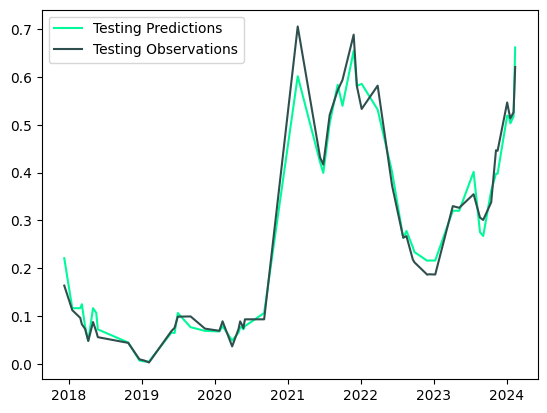

In [ ]:
plt.plot(dates_test,test_predict1,color='mediumspringgreen')
plt.plot(dates_test,original_ytest1,color='darkslategray')
plt.legend(['Testing Predictions', 'Testing Observations'])
# print(X_test.getIndexOf())
# print(Y_test)